In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.contrib.gp as gp
import scipy.linalg
import torch

# rng = np.random.default_rng(seed=1209)
plt.style.use("ggplot")
pyro.clear_param_store()


## Compute $x$ and $w$

In [2]:
l = 101
x = np.linspace(0, 1, l)
w = np.full(l, 1 / (l - 1))
w[0] = w[-1] = 1 / (2 * l - 2)

## Define our choice of kernel from B1

In [3]:
# RBF length 0.46064215898513794 var 1.2840211391448975
# PERIODIC per 0.17793160676956177 length 3.9094502925872803 var 1.4371237754821777

rbf = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(1.2840211391448975),
    lengthscale=torch.tensor(0.460642158),
)

periodic = gp.kernels.Periodic(
    input_dim=1,
    variance=torch.tensor(1.4371237754821777),
    lengthscale=torch.tensor(3.9094502925872803),
    period=torch.tensor(0.17793160676956177),
)


kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)


In [4]:
def compute_kernel_matrix(kernel, x, y):
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    return kernel.forward(x, y).detach().numpy()


## Plotting of 5 samples from $f | X, \hat{q}$ for $\hat{q} \in [0,5,10]$

LinAlgError: 41-th leading minor of the array is not positive definite

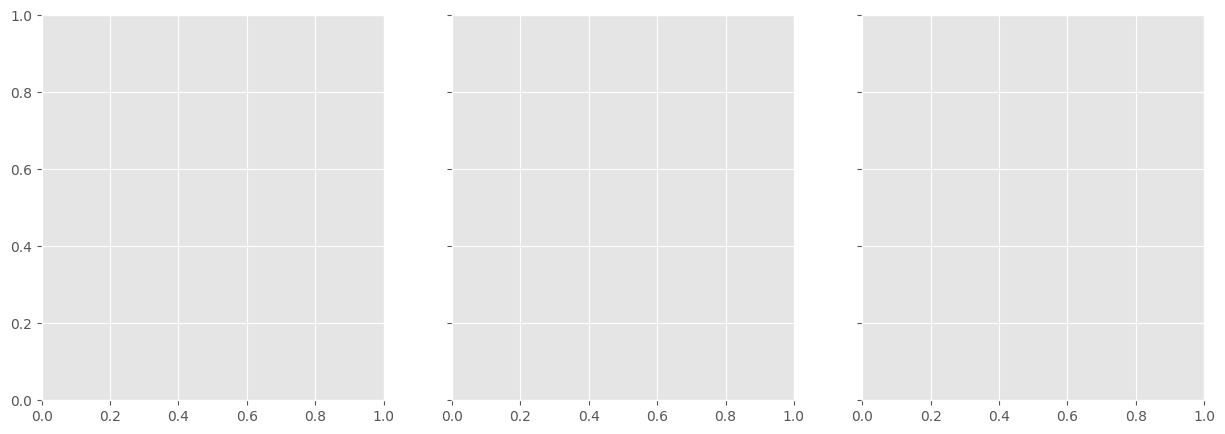

In [ ]:
# Number of samples to draw
n_samples = 5

# Compute kernel matrix for $x_i = \frac{i-1}{l-1}$ and $x_j = \frac{j-1}{l-1}$
Kx = compute_kernel_matrix(kernel, x, x)

# Share x-axis and y-axis for better comparison
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for i, q_hat in enumerate([0, 5, 10]):
    # Compute mean and covariance of the conditional distribution given $X$ and $\hat{q}$
    Kx_w = Kx @ w  # called $\Sigma_{f\hat{q}}$ in deleverable 1
    w_Kx_w = w @ Kx_w  # called $\Sigma_{\hat{q}f}$

    # These are the formulas derived for deliverable 1
    mu = Kx_w / w_Kx_w * q_hat
    cov = Kx - np.outer(Kx_w / w_Kx_w, Kx_w)

    # inverse of the covariance matrix
    foo = np.linalg.inv(cov)

    L = scipy.linalg.cholesky(cov + 1e-10 * np.eye(len(x)), lower=True)

    # Draw samples from the conditional distribution
    for _ in range(n_samples):
        sample = mu + L @ np.random.normal(0, 1, len(x))
        ax[i].plot(x, sample)
        ax[i].hlines(q_hat, 0, 1, colors="black", linestyles="--")

        # print(np.sum(sample * w))

    ax[i].set(title=r"$\hat{q}=$" + f"{q_hat}", xlabel="x", xlim=(0, 1))
    if i == 0:
        ax[i].set(ylabel="f(x)")

fig.suptitle(r"Samples from $f | X, \hat{q}$ ")
plt.tight_layout()
plt.savefig("./figures/samples_f_given_X_q.png", dpi=600)
plt.show()


## Does covariance matrix has full rank

In [11]:
# Perform eigen decomposition to get the principal components
eigenvalues, eigenvectors = np.linalg.eigh(Kx)

# Normalize the eigenvectors (principal components)
principal_components = eigenvectors

# Check orthogonality
orthogonal = True
tolerance = 0.1
for pc in principal_components.T:  # Transpose to iterate over components
    dot_product = np.dot(w, pc)
    if np.abs(dot_product) > tolerance:
        orthogonal = False
        break

print("Are the weights orthogonal to the principal components?", orthogonal)

Are the weights orthogonal to the principal components? True


## Plots of posterior $f\vert\mathcal{D}$

In [380]:
def g(x):
    return -(np.sin(6 * np.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


### Observations in dataset $\mathcal{D}$

In [381]:
Dx = np.array([0, 0.25, 0.5])
Dy = np.array([1.46, 0.93, 2.76])

In [382]:
# Kernel matrix for the observations + noise for the diagonal - for numerical stability when inverting
KD = compute_kernel_matrix(kernel, Dx, Dx) + np.eye(len(Dx)) * 0.01
# Inverse kernel matrix following notations from lecture slides
G = np.linalg.inv(KD)
alpha = G @ Dy

# Cross-covariance between grid and observations
KxDx = compute_kernel_matrix(kernel, Dx, x)


In [383]:
# Posterior mean and covariance without constraint
# These are the formulas from slide 28 on GPs by Oswin Krause
mu_fD = KxDx.T @ alpha
sigma_fD = Kx - KxDx.T @ G @ KxDx


In [384]:
# Cholesky decomposition used sampling as hinted in exam text
# add jitter for numerical stability
L_fD = scipy.linalg.cholesky(sigma_fD + 1e-5 * np.eye(len(x)), lower=True)


In [385]:
# 5 samples from the posterior f|D
samples_fD = [mu_fD + L_fD @ np.random.normal(size=len(x)) for _ in range(n_samples)]
std_fD = np.sqrt(np.diag(sigma_fD))


### Plotting the mean and samples for f|D

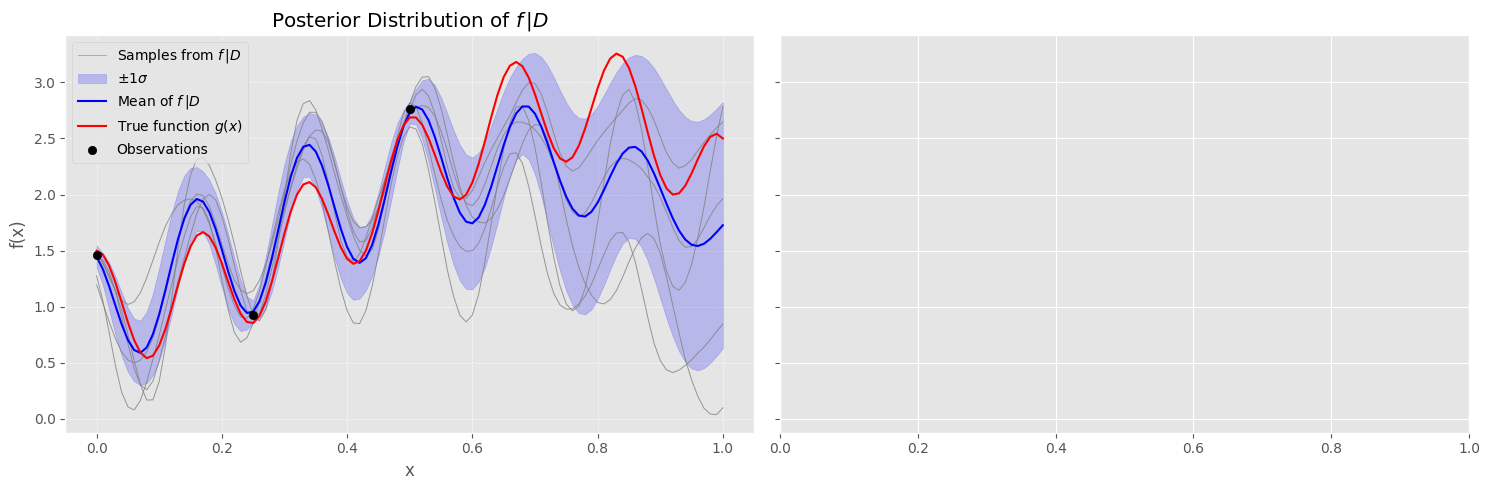

In [386]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(15, 5), sharey=True, tight_layout=True
)

# Plot sample functions with lighter colors and no labels
for sample in samples_fD:
    ax[0].plot(x, sample, color="gray", lw=0.7, alpha=0.8)

# Plot the ±1σ interval with transparency
ax[0].fill_between(
    x, mu_fD - std_fD, mu_fD + std_fD, color="blue", alpha=0.2, label=r"$\pm 1\sigma$"
)

# Plot the mean function
ax[0].plot(x, mu_fD, label=r"Mean of $f\, \vert D$", linewidth=1.5, color="blue")

# Plot the true function
ax[0].plot(x, g(x), color="red", linewidth=1.5, label=r"True function $g(x)$")

# Plot observations
ax[0].scatter(Dx, Dy, color="black", marker="o", label="Observations", zorder=5)

# Add axis labels
ax[0].set_xlabel("x")
ax[0].set_ylabel("f(x)")

# Add title
ax[0].set_title(r"Posterior Distribution of $f\, \vert D$")

# Add grid
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.8)

# Simplify legend
handles, labels = ax[0].get_legend_handles_labels()
# Replace individual sample labels with a single entry
sample_line = plt.Line2D([0], [0], color="gray", lw=0.5, alpha=0.8)
new_handles = [sample_line] + handles
new_labels = [r"Samples from $f\, \vert D$"] + labels
ax[0].legend(new_handles, new_labels, loc="upper left")

# plt.close(fig)

Adjust for Linear Constraint:
    - **Compute `v`:** This is the covariance between the Gaussian process and the constraint.
    - **Compute `c_var`:** This is the variance of the constraint.
    - **Compute `delta`:** The difference between the desired constraint value and the expected value under the current model.
    - **Compute `K_const`:** This is used to adjust the mean.
    - **Update the Mean and Covariance:** Using the formulas for conditioning a Gaussian distribution on a linear constraint.<>

In [387]:
# Now adjust for the linear constraint w f = 2 = q
q_hat = 2
# This is the covariance between the Gaussian process and the linear constraint
v = sigma_fD @ w.reshape(-1, 1)
# Variance of the linear constraint
qhat_var = w @ v


In [388]:
# Difference between the desired constraint value and the expected value under the current model.
delta = q_hat - w @ mu_fD

In [389]:
# Compute K = v / c_var
K_const = v / qhat_var  # n x 1 vector


In [390]:
# Update mean
mu_qhat = mu_fD + K_const.flatten() * delta

# Update covariance
sigma_qhat = sigma_fD - (v @ v.T) / qhat_var

# Cholesky decomposition used sampling as hinted in exam text
# add jitter for numerical stability
L_fDq = scipy.linalg.cholesky(sigma_qhat + 1e-5 * np.eye(len(x)), lower=True)


# Samples from the adjusted Gaussian process
samples_fDq = [
    mu_qhat + L_fDq @ np.random.normal(size=len(x)) for _ in range(n_samples)
]

std_fDq = np.sqrt(np.diag(sigma_qhat))

### Plot the mean and samples for $f \vert \hat{q}, \mathcal{D}$

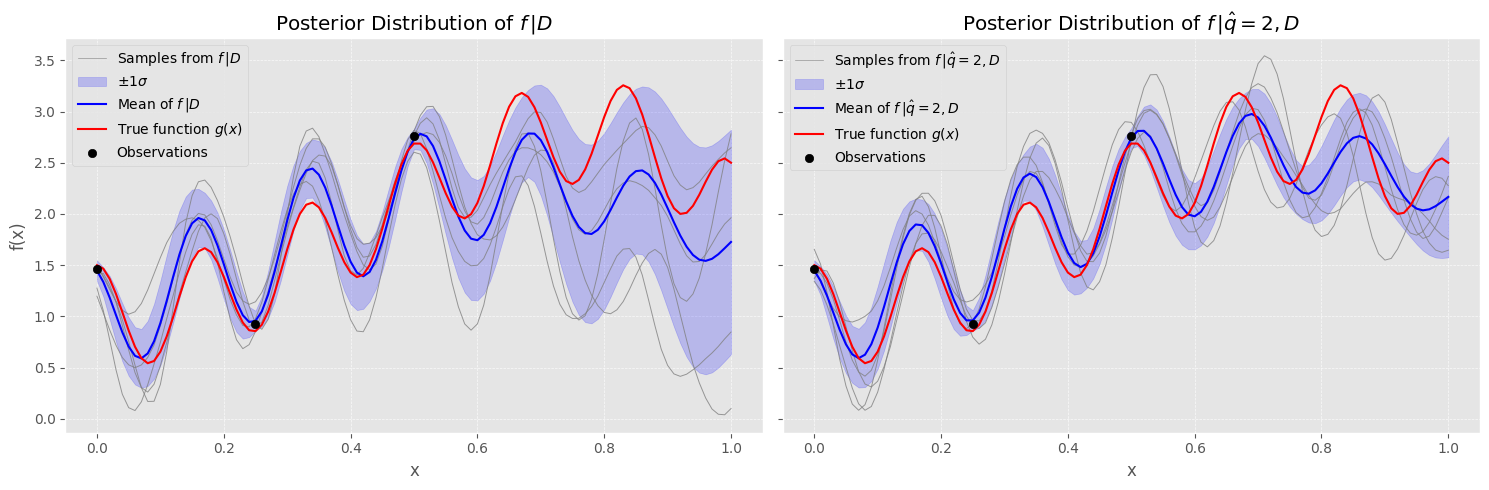

In [391]:
for sample in samples_fDq:
    ax[1].plot(x, sample, color="gray", lw=0.7, alpha=0.8)

# Plot the ±1σ interval with transparency
ax[1].fill_between(
    x,
    mu_qhat - std_fDq,
    mu_qhat + std_fDq,
    color="blue",
    alpha=0.2,
    label=r"$\pm 1\sigma$",
)

# Plot the mean function
ax[1].plot(
    x, mu_qhat, label=r"Mean of $f\, \vert \hat{q}=2,D$", linewidth=1.5, color="blue"
)

# Plot the true function
ax[1].plot(x, g(x), color="red", linewidth=1.5, label=r"True function $g(x)$")

# Plot observations
ax[1].scatter(Dx, Dy, color="black", marker="o", label="Observations", zorder=5)

# Add axis labels
ax[1].set_xlabel("x")
# ax[1].set_ylabel("f(x)")

# Add title
ax[1].set_title(r"Posterior Distribution of $f\, \vert \hat{q}=2,D$")

# Add grid
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.8)

# Simplify legend
handles, labels = ax[1].get_legend_handles_labels()
# Replace individual sample labels with a single entry
sample_line = plt.Line2D([0], [0], color="gray", lw=0.5, alpha=0.8)
new_handles = [sample_line] + handles
new_labels = [r"Samples from $f\, \vert \hat{q}=2, D$"] + labels
ax[1].legend(new_handles, new_labels, loc="upper left")
# plt.savefig("./figures/posterior_f_given_q_D.png", dpi=600)
plt.show()
fig

Yes, given that the covariance matrix of $(q, f \mid X)$ is partitioned into block matrices, it is indeed possible to express the covariance matrix of the conditional distribution $(f \mid X, q)$ in terms of these blocks.

### **Understanding the Block Covariance Matrix**

When dealing with multivariate normal distributions, the joint covariance matrix can be partitioned into blocks corresponding to different subsets of variables. Specifically, for the joint distribution of $(q, f \mid X)$, the covariance matrix $\Sigma$ can be partitioned as:

$$
\Sigma = \begin{bmatrix}
\Sigma_{qq} & \Sigma_{qf} \\
\Sigma_{fq} & \Sigma_{ff} \\
\end{bmatrix}
$$

- $\Sigma_{qq}$ is the covariance matrix of $q$.
- $\Sigma_{ff}$ is the covariance matrix of $f$.
- $\Sigma_{qf}$ (and $\Sigma_{fq} = \Sigma_{qf}^\top$) represents the cross-covariance between $q$ and $f$.

### **Computing the Conditional Covariance Matrix**

For a joint multivariate normal distribution, the conditional distribution of one subset of variables given another is also normal, with its mean and covariance determined by the joint parameters. The covariance matrix of the conditional distribution $(f \mid X, q)$ is given by:

$$
\text{Cov}(f \mid X, q) = \Sigma_{ff} - \Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}
$$

Here's how this works:

1. **$\Sigma_{ff}$**: Represents the variance (or covariance) of $f$ when considered alone.
2. **$\Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}$**: Adjusts for the linear relationship between $f$ and $q$ captured in the cross-covariance blocks.

This formula effectively "subtracts out" the part of $f$'s variability that is explained by its linear relationship with $q$, leaving the residual variability that constitutes the covariance of $f$ given $q$.

### **Implications**

- **Direct Computation**: With the block elements $\Sigma_{qq}$, $\Sigma_{qf}$, and $\Sigma_{ff}$, you can directly compute $\text{Cov}(f \mid X, q)$.
- **No Need for Full Distribution**: You don't need to recompute or re-estimate the entire joint distribution; the block components suffice for calculating the conditional covariance.
- **Applicability**: This approach is standard in multivariate statistics and is widely used in fields like Bayesian statistics, signal processing, and machine learning (e.g., in Gaussian processes).

### **Example**

Suppose:

$$
\Sigma = \begin{bmatrix}
\Sigma_{qq} & \Sigma_{qf} \\
\Sigma_{qf}^\top & \Sigma_{ff} \\
\end{bmatrix} = \begin{bmatrix}
\begin{bmatrix}
\sigma_{q1}^2 & \rho_{q1q2} \sigma_{q1} \sigma_{q2} \\
\rho_{q1q2} \sigma_{q1} \sigma_{q2} & \sigma_{q2}^2 \\
\end{bmatrix} & \begin{bmatrix}
\rho_{q1f} \sigma_{q1} \sigma_f \\
\rho_{q2f} \sigma_{q2} \sigma_f \\
\end{bmatrix} \\
\begin{bmatrix}
\rho_{q1f} \sigma_{q1} \sigma_f \\
\rho_{q2f} \sigma_{q2} \sigma_f \\
\end{bmatrix}^\top & \sigma_f^2 \\
\end{bmatrix}
$$

Using the formula:

$$
\text{Cov}(f \mid X, q) = \sigma_f^2 - [\Sigma_{fq}] \Sigma_{qq}^{-1} [\Sigma_{qf}]
$$

You can compute the conditional covariance by plugging in the known values.

When dealing with multivariate normal distributions, understanding the impact of conditioning on the covariance structure is crucial. Let's address your question:

### **Question Recap**

- **Given**: The covariance matrix $\Sigma_{ff}$ (the covariance of $f$) has full rank (i.e., it is positive definite).
- **Question**: Can we say anything about the rank of the conditional covariance matrix $\text{Cov}(f \mid X, q)$ given this information?

### **Short Answer**

No, even if $\Sigma_{ff}$ has full rank, we cannot generally infer that $\text{Cov}(f \mid X, q)$ will also have full rank. The rank of the conditional covariance matrix depends on the relationship between $f$ and $q$ encoded in the cross-covariance $\Sigma_{fq}$. Conditioning can reduce the rank, potentially making $\text{Cov}(f \mid X, q)$ less than full rank.

---

### **Detailed Explanation**

#### **Understanding the Conditional Covariance**

The conditional covariance of $f$ given $q$ (and $X$) in a joint Gaussian setting is calculated using the formula:

$$
\text{Cov}(f \mid X, q) = \Sigma_{ff} - \Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}
$$

- **$\Sigma_{ff}$**: Covariance of $f$, assumed to be full rank (positive definite).
- **$\Sigma_{qf}$** and **$\Sigma_{fq}$**: Cross-covariance matrices between $q$ and $f$.
- **$\Sigma_{qq}$**: Covariance of $q$, assumed to be invertible (positive definite).

#### **Impact of Conditioning on Rank**

1. **Full Rank of $\Sigma_{ff}$**:

   - A full-rank $\Sigma_{ff}$ implies that $f$ has variability in all its dimensions when considered marginally (without conditioning on $q$).

2. **Effect of $\Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}$**:

   - The term $\Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}$ represents the part of $f$'s variability that is linearly explained by $q$.
   - This term is **positive semi-definite** because it's of the form $A B A^\top$ with $B$ positive definite.

3. **Subtraction Reduces Rank**:

   - Subtracting a positive semi-definite matrix from $\Sigma_{ff}$ can reduce the rank of the resulting conditional covariance matrix.
   - If $f$ is highly correlated with $q$, a significant portion of its variability is "explained away" when conditioning on $q$, potentially reducing rank.

#### **Possible Scenarios**

1. **No Correlation between $f$ and $q$**:

   - If $\Sigma_{qf} = 0$, then $\text{Cov}(f \mid X, q) = \Sigma_{ff}$.
   - In this case, the rank remains full since no variability is removed through conditioning.

2. **Perfect Linear Relationship**:

   - If $f$ can be expressed as a linear function of $q$ (i.e., $f = A q$ deterministically), then:
     - $\Sigma_{ff} = \Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}$.
     - $\text{Cov}(f \mid X, q) = \Sigma_{ff} - \Sigma_{ff} = 0$.
     - The rank of the conditional covariance is zero.

3. **Partial Correlation**:

   - When $f$ and $q$ are partially correlated, the rank of $\text{Cov}(f \mid X, q)$ can be anywhere between full rank and reduced rank, depending on the strength and structure of their relationship.
   - The more $f$ depends on $q$, the more the rank is likely to reduce upon conditioning.

#### **Conclusion**

- **Rank Not Guaranteed**: We cannot guarantee that $\text{Cov}(f \mid X, q)$ will be full rank even if $\Sigma_{ff}$ is full rank.
- **Dependence on Cross-Covariance**: The reduction in rank depends critically on $\Sigma_{fq}$ (and $\Sigma_{qf}$), which captures the dependence between $f$ and $q$.
- **Need for Additional Information**: Without further information about the relationship between $f$ and $q$, we cannot make definitive statements about the rank of $\text{Cov}(f \mid X, q)$.

### **Implications**

- **Positive Semi-Definiteness**: While the conditional covariance matrix $\text{Cov}(f \mid X, q)$ is always positive semi-definite, its rank may be less than full due to the subtraction of a positive semi-definite matrix.
- **Practical Considerations**: In applications like regression, signal processing, or machine learning, this means that conditioning on certain variables can reduce the effective dimensionality of the uncertainty in $f$.

---

**Answer:** No; even if Σ_ff has full rank, we cannot generally determine the rank of Cov(f | X, q) without more information—the conditioning on q can reduce the rank, so Cov(f | X, q) may have lower rank depending on the cross-covariance between f and q.

Yes, given that \(\Sigma_{ff}\) has full rank and that \(q\) is a linear combination of elements from \(f\), we can make a definitive statement about the rank of the conditional covariance matrix \(\text{Cov}(f \mid X, q)\). Specifically, conditioning on \(q\) reduces the rank of \(\text{Cov}(f \mid X, q)\) by the rank of the linear transformation relating \(f\) to \(q\).

### **Detailed Explanation**

#### **Setup**

1. **Variables and Dimensions**:

   - Let \(f \in \mathbb{R}^n\) be a random vector.
   - Let \(q \in \mathbb{R}^k\) be a linear combination of elements from \(f\).
   - \(A\) is a \(k \times n\) matrix representing the linear relationship between \(f\) and \(q\): \(q = A f\).

2. **Covariance Matrices**:

   - \(\Sigma_{ff}\) is the covariance matrix of \(f\), assumed to be full rank (positive definite), so \(\text{rank}(\Sigma_{ff}) = n\).
   - The joint distribution of \((q, f)\) is jointly Gaussian due to the linear relationship and the normality of \(f\).

#### **Computing the Conditional Covariance**

The conditional covariance of \(f\) given \(q\) is given by:

\[
\text{Cov}(f \mid X, q) = \Sigma_{ff} - \Sigma_{fq} \Sigma_{qq}^{-1} \Sigma_{qf}
\]

Where:

- \(\Sigma_{qf} = \text{Cov}(q, f) = A \Sigma_{ff}\)
- \(\Sigma_{fq} = \Sigma_{qf}^\top = \Sigma_{ff} A^\top\)
- \(\Sigma_{qq} = \text{Cov}(q, q) = A \Sigma_{ff} A^\top\)

Substituting these into the formula:

\[
\text{Cov}(f \mid X, q) = \Sigma_{ff} - \Sigma_{ff} A^\top (A \Sigma_{ff} A^\top)^{-1} A \Sigma_{ff}
\]

#### **Analyzing the Rank of the Conditional Covariance**

1. **Factorization**:

   Let’s factor out \(\Sigma_{ff}\) (which is invertible):

   \[
   \text{Cov}(f \mid X, q) = \Sigma_{ff} \left( I - A^\top (A \Sigma_{ff} A^\top)^{-1} A \Sigma_{ff} \right)
   \]

2. **Introducing Transformation**:

   Let’s define:

   - \(B = \Sigma_{ff}^{1/2}\), so \(\Sigma_{ff} = B B^\top\) (since \(\Sigma_{ff}\) is positive definite).
   - \(S = A B\)
   
   Then:

   \[
   \text{Cov}(f \mid X, q) = B \left( I - S^\top (S S^\top)^{-1} S \right) B^\top
   \]

3. **Interpreting the Projection Matrix**:

   - The matrix \(P = S^\top (S S^\top)^{-1} S\) is a projection matrix onto the row space of \(S\).
   - \(I - P\) projects onto the orthogonal complement of the row space of \(S\).

4. **Determining the Rank**:

   - The rank of \(\text{Cov}(f \mid X, q)\) is equal to the rank of \(I - P\) since \(B\) is invertible.
   - \(\text{rank}(I - P) = n - \text{rank}(P) = n - \text{rank}(S)\)
   - Since \(S = A B\) and \(B\) is invertible, \(\text{rank}(S) = \text{rank}(A)\)

   Therefore:

   \[
   \text{rank}(\text{Cov}(f \mid X, q)) = n - \text{rank}(A)
   \]

#### **Conclusion and Implications**

- **Rank Reduction**: The rank of \(\text{Cov}(f \mid X, q)\) is reduced by the rank of \(A\), the matrix defining the linear combination of \(f\) to form \(q\).
- **Full Rank vs. Reduced Rank**:
  - If \(A\) has full rank \(k\) (with \(k \leq n\)), then \(\text{Cov}(f \mid X, q)\) has rank \(n - k\).
  - If \(A\) is not of full rank, the reduction in rank corresponds to \(\text{rank}(A)\).

- **Interpretation**:
  - **Information Gain**: Conditioning on \(q\) removes uncertainty in the directions of \(f\) that are linearly related to \(q\).
  - **Degeneracy**: The conditional covariance becomes singular (less than full rank) if \(A\) has rank greater than zero.

- **Special Cases**:
  - **No Conditioning**: If \(A\) is a zero matrix (i.e., \(q\) does not depend on \(f\)), then \(\text{Cov}(f \mid X, q) = \Sigma_{ff}\) retains full rank.
  - **Full Information**: If \(A\) has rank \(n\), implying \(q\) fully determines \(f\), then \(\text{Cov}(f \mid X, q)\) has rank zero—the uncertainty is entirely removed.

### **Answer**

**Yes; if Σ_ff is full rank and q is a linear combination of elements from f, then conditioning on q reduces the rank of Cov(f | X, q) by the rank of that linear combination. Specifically, Cov(f | X, q) has rank equal to the rank of Σ_ff minus the rank of q’s linear relationship to f.**

This means that:

- **The rank of Cov(f | X, q) is n minus the rank of A** (where A is the matrix such that \(q = A f\)).
- **Conditioning on q reduces the uncertainty in f**, eliminating variability in the directions spanned by the rows of A.
- **Cov(f | X, q) becomes singular** (less than full rank) if \(q\) depends non-trivially on \(f\).

So, knowing that \(q\) is a linear combination of \(f\) allows us to conclude that the rank of the conditional covariance \(\text{Cov}(f \mid X, q)\) is reduced accordingly.

## Integral constraint

To adjust the mean and covariance matrix of your Gaussian process to account for the linear constraint $\sum_{i=1}^l w_i f(x_i) = 2$, you can condition the Gaussian process on this constraint using properties of multivariate normal distributions.

Below is Python code that demonstrates how to implement this. The code performs the following steps:

1. Defines the grid and observations.
2. Constructs the prior mean and covariance matrix for the Gaussian process.
3. Computes the posterior mean and covariance given the observations using Gaussian process regression.
4. Adjusts the posterior mean and covariance to account for the linear constraint.
5. Samples from the constrained Gaussian process.

```python
import numpy as np
import matplotlib.pyplot as plt

# Define the grid
x_grid = np.linspace(0, 1, 101)  # 101 points from 0 to 1
n = len(x_grid)

# Observations
x_obs = np.array([0, 0.25, 0.5])
y_obs = np.array([1.46, 0.93, 2.76])

# Indices of observations in the grid
indices_obs = np.searchsorted(x_grid, x_obs)

# Define the weights w_i for the constraint
# Assuming w_i are given (you need to define them based on your specific problem)
# For example, let's suppose w_i = 1 for x_i in the first l grid points, zero otherwise
l = 50  # number of terms in the sum for the constraint
w = np.zeros(n)
w[:l] = 1  # set weights to 1 for the first l points

# The constraint sum_{i=1}^l w_i * f(x_i) = 2
A = w  # A is a vector of weights
b = 2  # The right-hand side of the constraint

# Define the kernel function (e.g., squared exponential kernel)
def kernel(a, b, length_scale=0.1, sigma_f=1.0):
    sqdist = np.subtract.outer(a, b)**2
    return sigma_f**2 * np.exp(-0.5 * sqdist / length_scale**2)

# Compute the covariance matrices
K = kernel(x_grid, x_grid)
K_obs = K[np.ix_(indices_obs, indices_obs)]  # Covariance between observations
K_s = K[np.ix_(np.arange(n), indices_obs)]   # Covariance between grid and observations
K_ss = K  # Covariance between grid points

# Add a small noise term to the diagonal of K_obs for numerical stability
noise = 1e-8
K_obs += noise * np.eye(len(indices_obs))

# Compute the posterior mean and covariance matrix given observations
K_obs_inv = np.linalg.inv(K_obs)
mu_post = K_s @ K_obs_inv @ y_obs
Sigma_post = K_ss - K_s @ K_obs_inv @ K_s.T

# Now adjust for the linear constraint A f = b
# Compute v = Sigma_post @ A.T
v = Sigma_post @ A.reshape(-1, 1)  # v is n x 1 vector

# Compute c_var = A @ v
c_var = A @ v  # scalar

# Compute delta = b - A @ mu_post
delta = b - A @ mu_post  # scalar

# Compute K = v / c_var
K_const = v / c_var  # n x 1 vector

# Update mean
mu_c = mu_post + K_const.flatten() * delta

# Update covariance
Sigma_c = Sigma_post - (v @ v.T) / c_var

# Now you can sample from the adjusted Gaussian process
# For example, draw 5 samples
n_samples = 5
samples = np.random.multivariate_normal(mu_c, Sigma_c, n_samples)

# Plot the results
plt.figure(figsize=(12, 6))
for i in range(n_samples):
    plt.plot(x_grid, samples[i], alpha=0.5)
plt.plot(x_grid, mu_c, 'k', lw=2, label='Posterior mean with constraint')
plt.scatter(x_obs, y_obs, c='r', marker='o', label='Observations')
plt.legend()
plt.title('Gaussian Process Samples with Linear Constraint')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()
```

**Explanation:**

1. **Define the grid and observations:** We create an array `x_grid` of 101 points from 0 to 1, and specify the observed points `x_obs` and their corresponding values `y_obs`.

2. **Kernel Function:** A squared exponential kernel function is defined to compute the covariance matrices. You can adjust the `length_scale` and `sigma_f` parameters to suit your specific application.

3. **Compute Covariance Matrices:** We compute the prior covariance matrix `K`, and extract the submatrices relevant for the observations and between the grid points and observations.

4. **Gaussian Process Regression:** We compute the posterior mean `mu_post` and covariance `Sigma_post` given the observations using standard Gaussian process regression formulas.

5. **Adjust for Linear Constraint:**
    - **Compute `v`:** This is the covariance between the Gaussian process and the constraint.
    - **Compute `c_var`:** This is the variance of the constraint.
    - **Compute `delta`:** The difference between the desired constraint value and the expected value under the current model.
    - **Compute `K_const`:** This is used to adjust the mean.
    - **Update the Mean and Covariance:** Using the formulas for conditioning a Gaussian distribution on a linear constraint.

6. **Sampling and Visualization:** We draw samples from the adjusted Gaussian process and plot them along with the adjusted mean and the observations.

**Note:** In this code, `w` was assumed to be 1 for the first `l` points and zero elsewhere, but you should adjust `w` based on your specific weights. Additionally, the choice of kernel and its parameters (e.g., `length_scale`, `sigma_f`) can significantly affect the results, so you may need to adjust these to fit your data appropriately.

Certainly! Conditioning a Gaussian (normal) distribution on a linear constraint is a fundamental concept in multivariate statistics and Gaussian process theory. Here's a detailed explanation of the formulas used to adjust the mean and covariance matrix when conditioning on a linear constraint, along with references to their origin.

### **Conditioning a Multivariate Normal Distribution on a Linear Constraint**

When we have a multivariate normal (Gaussian) distribution for a random vector $\mathbf{f} \in \mathbb{R}^n$ with mean $\boldsymbol{\mu}$ and covariance matrix $\mathbf{\Sigma}$:

$$
\mathbf{f} \sim \mathcal{N}(\boldsymbol{\mu}, \mathbf{\Sigma}),
$$

and we impose a linear constraint of the form:

$$
\mathbf{A}^\top \mathbf{f} = b,
$$

where $\mathbf{A} \in \mathbb{R}^n$ is a known vector of coefficients (weights), and $b$ is a scalar constant, the distribution of $\mathbf{f}$ conditioned on this constraint remains Gaussian. The updated (conditional) mean $\boldsymbol{\mu}_c$ and covariance matrix $\mathbf{\Sigma}_c$ are given by:

1. **Updated Mean:**

$$
\boldsymbol{\mu}_c = \boldsymbol{\mu} + \mathbf{\Sigma} \mathbf{A} \left( \mathbf{A}^\top \mathbf{\Sigma} \mathbf{A} \right)^{-1} (b - \mathbf{A}^\top \boldsymbol{\mu}).
$$

2. **Updated Covariance Matrix:**

$$
\mathbf{\Sigma}_c = \mathbf{\Sigma} - \mathbf{\Sigma} \mathbf{A} \left( \mathbf{A}^\top \mathbf{\Sigma} \mathbf{A} \right)^{-1} \mathbf{A}^\top \mathbf{\Sigma}.
$$

#### **Explanation of the Formulas:**

- **$\boldsymbol{\mu}_c$:** The updated mean is the original mean adjusted by the expected deviation due to the constraint. The term $(b - \mathbf{A}^\top \boldsymbol{\mu})$ represents the difference between the desired constraint value and the expected value of the constraint under the original distribution.
  
- **$\mathbf{\Sigma}_c$:** The updated covariance accounts for the reduction in uncertainty due to the constraint. The term subtracted from $\mathbf{\Sigma}$ represents the amount by which the variance is reduced because of the constraint.

#### **Derivation Origin:**

These formulas arise from properties of the multivariate normal distribution. Specifically, they are derived from the idea that conditioning a normal distribution on a linear function leads to another normal distribution. This is a well-established result in statistics and can be found in several standard textbooks and papers.

**References:**

- **"An Introduction to Multivariate Statistical Analysis" by T.W. Anderson (3rd Edition):** This classic text provides a comprehensive treatment of multivariate normal distributions, including conditioning on linear constraints (see Chapter 2).

- **"Gaussian Processes for Machine Learning" by Carl E. Rasmussen and Christopher K. I. Williams (2006):** While primarily focused on Gaussian processes, this book also touches on conditioning and inference (see Section 2.3).

- **"Statistical Inference" by George Casella and Roger L. Berger (2nd Edition):** Offers a detailed explanation of properties of the normal distribution, including conditional distributions (see Chapter 5).

### **Application in Gaussian Process Regression with Linear Constraints**

In the context of Gaussian processes (GPs), the function values $f(x)$ at different points $x$ are assumed to follow a multivariate normal distribution. When we have observations and wish to impose a linear constraint on the function values, we adjust the posterior mean and covariance of the GP accordingly.

#### **Steps in the Code Explained:**

Let's map the terms from the formulas to the variables used in the Python code you provided.

1. **Define the Prior Mean and Covariance:**

   - The prior mean $\boldsymbol{\mu}$ is often assumed to be zero or any prior belief about the function.
   - The prior covariance $\mathbf{\Sigma}$ is computed using the kernel function $K$.

2. **Compute the Posterior Mean and Covariance Given Observations:**

   - **Posterior Mean ($\boldsymbol{\mu}_{\text{post}}$):**

     $$
     \boldsymbol{\mu}_{\text{post}} = K_s K_{\text{obs}}^{-1} \mathbf{y}_{\text{obs}},
     $$

     where $K_s$ is the covariance between the grid points and observations, $K_{\text{obs}}$ is the covariance between observations, and $\mathbf{y}_{\text{obs}}$ are the observed values.

   - **Posterior Covariance ($\mathbf{\Sigma}_{\text{post}}$):**

     $$
     \mathbf{\Sigma}_{\text{post}} = K_{ss} - K_s K_{\text{obs}}^{-1} K_s^\top,
     $$

     where $K_{ss}$ is the covariance between grid points.

3. **Impose the Linear Constraint:**

   - **Define the Constraint:**

     The constraint is $\mathbf{A}^\top \mathbf{f} = b$, where $\mathbf{A} = \mathbf{w}$ (the weights $w_i$), and $b = 2$.

   - **Compute $v = \mathbf{\Sigma}_{\text{post}} \mathbf{A}$:**

     Corresponds to $\mathbf{\Sigma} \mathbf{A}$ in the formulas.

   - **Compute $c_{\text{var}} = \mathbf{A}^\top v$:**

     Corresponds to $\mathbf{A}^\top \mathbf{\Sigma} \mathbf{A}$, which is the variance of the constraint.

   - **Compute $\delta = b - \mathbf{A}^\top \boldsymbol{\mu}_{\text{post}}$:**

     Represents the difference between the desired constraint value and its expected value under the posterior.

   - **Update the Mean ($\boldsymbol{\mu}_c$):**

     $$
     \boldsymbol{\mu}_c = \boldsymbol{\mu}_{\text{post}} + v \left( c_{\text{var}} \right)^{-1} \delta.
     $$

   - **Update the Covariance ($\mathbf{\Sigma}_c$):**

     $$
     \mathbf{\Sigma}_c = \mathbf{\Sigma}_{\text{post}} - v v^\top \left( c_{\text{var}} \right)^{-1}.
     $$

#### **Interpreting the Code Variables:**

- **`v = Sigma_post @ A.reshape(-1, 1)`:**

  Computes $\mathbf{\Sigma}_{\text{post}} \mathbf{A}$.

- **`c_var = A @ v`:**

  Computes $\mathbf{A}^\top \mathbf{\Sigma}_{\text{post}} \mathbf{A}$.

- **`delta = b - A @ mu_post`:**

  The difference between the target constraint value and its expected value.

- **`K_const = v / c_var`:**

  This is $\mathbf{\Sigma}_{\text{post}} \mathbf{A} \left( \mathbf{A}^\top \mathbf{\Sigma}_{\text{post}} \mathbf{A} \right)^{-1}$, used to update the mean.

- **`mu_c = mu_post + K_const.flatten() * delta`:**

  Updates the mean according to the constraint.

- **`Sigma_c = Sigma_post - (v @ v.T) / c_var`:**

  Updates the covariance matrix.

### **Understanding the Impact of the Linear Constraint**

By imposing the constraint $\mathbf{A}^\top \mathbf{f} = b$, we are essentially "reshaping" our posterior belief about the function $f(x)$ so that the linear combination specified by $\mathbf{A}$ exactly equals $b$.

- The updated mean $\boldsymbol{\mu}_c$ adjusts to satisfy the constraint while remaining as close as possible to $\boldsymbol{\mu}_{\text{post}}$ in a least-squares sense.

- The updated covariance $\mathbf{\Sigma}_c$ reflects the reduced uncertainty in directions impacted by the constraint.

### **Practical Implications**

In practice, conditioning on linear constraints is useful in scenarios such as:

- **Data assimilation:** Incorporating known linear relationships between variables.

- **Kriging with Known Sums:** In geostatistics, sometimes the sum of the variables is known (e.g., compositional data).

- **Physical Constraints:** Enforcing conservation laws or other physical constraints in modeling.

### **Additional References and Further Reading**

- **"Linear Algebra and Its Applications" by Gilbert Strang:** Provides foundational knowledge in linear algebra relevant to understanding these derivations.

- **"A Modern Approach to Probability Theory" by Bert Fristedt and Lawrence F. Gray:** Includes discussions on conditional distributions and Gaussian measures.

- **Research Papers:**

  - **"Constrained Gaussian Process Regression" by Jouni Hartikainen and Simo Särkkä (2011):** Discusses methods for incorporating linear operator constraints into GP regression.

    [Link to Paper](https://users.aalto.fi/~ssarkka/pub/neucon2011.pdf)

  - **"Gaussian Processes with Linear Operator Inequality Constraints" by Tor J. Ski, Michalis K. Titsias, and Neil D. Lawrence (2015):** Explores GP regression under linear inequality constraints.

    [Link to Paper](https://proceedings.neurips.cc/paper/2015/file/5acb0a4af9f06935374be5b1fd5190f7-Paper.pdf)

### **Conclusion**

By conditioning the Gaussian process on the linear constraint, we adjust our model to satisfy additional information, leading to more accurate predictions that adhere to known relationships. The formulas for updating the mean and covariance are grounded in the properties of the multivariate normal distribution and are essential tools in probabilistic modeling and inference.

---

**Note:** The implementation and derivation of these formulas assume that the covariance matrix $\mathbf{\Sigma}$ is positive definite and that $\mathbf{A}^\top \mathbf{\Sigma} \mathbf{A}$ is invertible. In practice, numerical issues may arise, and regularization or numerical stabilization techniques (e.g., adding a small noise term to the diagonal) are often employed.

Let me know if you need further clarification or assistance with any specific part of the implementation!